[View in Colaboratory](https://colab.research.google.com/github/xinliupitt/Projects/blob/master/0416_2.ipynb)

In [0]:
import numpy as np # https://docs.scipy.org/doc/numpy/reference/
import pandas as pd # https://pandas.pydata.org/pandas-docs/stable/
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
import seaborn as sns
import math

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
file_list = drive.ListFile({'q': "'1vghYJblRUxy5dtuGjBhfULjzorpeRz2A' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: 0416_2.ipynb, id: 1uAv0YKNDu0rZSkIy0yJuqgM-9TqgQeJo
title: 0417_House.ipynb, id: 19QZbIhaq6emuP6XrHWP8-dFCv04El5ej
title: 0416.ipynb, id: 1UKDd_j4f32FNN7cWf35XbevgsxeW8aav
title: 0415_Corrected_2.ipynb, id: 1Z9G5NalmB3KyEFnqV69T0qGyyPyxBARd
title: 0415.ipynb, id: 1PSvyfaVn00nx3Zc0hc4f0HdbqLMrpFPc
title: 0415_Corrected.ipynb, id: 1_cq7xdviFTDN05S0WvPLYPs_9KvgW2I5
title: 0414_House.ipynb, id: 1nqqlpVU2DtHOBDP24Hb51R0UBI4p9qRk
title: HousePrice_Progress.ipynb, id: 1BeFgZ-pZd8XVKqkrUidQtMzR5VfkHFEb
title: train.csv, id: 14TDFgAbfmwr5PcvhiZM1vTnB2xLwszxM
title: test.csv, id: 1ltkGSVLvUKXB3TjzjGCwbWQukz4hu6Ve
title: 0413.ipynb, id: 1CgQv2RAhHE6dMrBdWbwPgOKgZR8QQYHl
title: movie_metadata.csv, id: 1rX03SO_GIxPSLDbIole671LBYne3sp0g
title: IMDB_0411.ipynb, id: 1d02DJ1KMEvhNobQXTbI-5HvEJ3PC7r5T
title: IMDB_0328.ipynb, id: 1URA1g7B7n_sXWQg5_Wj52A9_geaDEi9K


In [0]:
train_downloaded = drive.CreateFile({'id': '1rX03SO_GIxPSLDbIole671LBYne3sp0g'})
train_downloaded.GetContentFile('movie_metadata.csv')

In [0]:
mov=pd.read_csv('movie_metadata.csv')

In [7]:
print(mov.columns.values)

['color' 'director_name' 'num_critic_for_reviews' 'duration'
 'director_facebook_likes' 'actor_3_facebook_likes' 'actor_2_name'
 'actor_1_facebook_likes' 'gross' 'genres' 'actor_1_name' 'movie_title'
 'num_voted_users' 'cast_total_facebook_likes' 'actor_3_name'
 'facenumber_in_poster' 'plot_keywords' 'movie_imdb_link'
 'num_user_for_reviews' 'language' 'country' 'content_rating' 'budget'
 'title_year' 'actor_2_facebook_likes' 'imdb_score' 'aspect_ratio'
 'movie_facebook_likes']


In [0]:
mov.drop(["aspect_ratio", "movie_imdb_link"], inplace=True, axis=1) # attributes not related to imdb score

In [0]:
mov.drop(["num_critic_for_reviews", "num_voted_users","num_user_for_reviews","movie_facebook_likes","imdb_score"], inplace=True, axis=1) # attributes cannot be known before a movie is shot
# gross is not dropped here for further use

In [10]:
print(mov.columns.values)

['color' 'director_name' 'duration' 'director_facebook_likes'
 'actor_3_facebook_likes' 'actor_2_name' 'actor_1_facebook_likes' 'gross'
 'genres' 'actor_1_name' 'movie_title' 'cast_total_facebook_likes'
 'actor_3_name' 'facenumber_in_poster' 'plot_keywords' 'language'
 'country' 'content_rating' 'budget' 'title_year' 'actor_2_facebook_likes']


In [0]:
mov.dropna(subset=['gross','content_rating','budget'],how='all',inplace=True)

In [0]:
mov = mov.drop( mov[ (mov.content_rating=='TV-14') | (mov.content_rating=='TV-PG') | 
                     (mov.content_rating=='TV-MA') |(mov.content_rating=='TV-G')|
                     (mov.content_rating=='TV-Y') |(mov.content_rating=='TV-Y7')].index)

In [0]:
values = {'content_rating': "Unrated"}
mov=mov.fillna(value=values)

In [0]:
mov.drop( mov[ (np.isnan(mov.gross)==True) & (np.isnan(mov.budget)==True) &
          ((mov.content_rating=="Unrated")|(mov.content_rating=="Not Rated"))].index, inplace=True)

In [0]:
mov.drop( mov[ (np.isnan(mov.gross)==True) | (np.isnan(mov.budget)==True)].index, inplace=True)

In [0]:
mov.reset_index(drop=True, inplace=True)

In [0]:
numeric_features=mov._get_numeric_data().columns.values.tolist()

text_features=mov.columns.values.tolist()
text_features=[i for i in text_features if i not in numeric_features]



string_features=["movie_title", "plot_keywords","genres"]

categorical_features=[i for i in text_features if i not in string_features]

In [19]:
numeric_features

['duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'gross',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'budget',
 'title_year',
 'actor_2_facebook_likes']

In [18]:
text_features

['color',
 'director_name',
 'actor_2_name',
 'genres',
 'actor_1_name',
 'movie_title',
 'actor_3_name',
 'plot_keywords',
 'language',
 'country',
 'content_rating']

In [0]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler 
imp=Imputer(missing_values="NaN", strategy="mean",axis=0) # here the strategy is subject to change.
mov[numeric_features]=imp.fit_transform(mov[numeric_features])





In [0]:
mov=pd.concat([mov,(mov['gross']-mov['budget'])/mov['budget']],axis=1)

In [0]:
mov['gross_RoI']=mov[0]

In [0]:
mov.drop([0], inplace=True, axis=1)

In [0]:
# convert to 100% cutoff -> 1.0
mov['gross_RoI_cut']=mov['gross_RoI']
for i, num in enumerate(mov.loc[:,'gross_RoI']):
  if num>=1.0:
    mov.loc[i,'gross_RoI_cut']=1
  else:
    mov.loc[i,'gross_RoI_cut']=0

In [0]:
mov.drop(["gross"], inplace=True, axis=1)

In [0]:
mov.drop(["gross_RoI"], inplace=True, axis=1)
# scl=StandardScaler() # do we really need this? Will we try PCA?
# mov[numeric_features]=scl.fit_transform(mov[numeric_features])

In [0]:
labels=mov["gross_RoI_cut"]
mov.drop(["gross_RoI_cut"], inplace=True, axis=1)

In [0]:
numeric_features.remove('gross')

In [31]:
numeric_features

['duration',
 'director_facebook_likes',
 'actor_3_facebook_likes',
 'actor_1_facebook_likes',
 'cast_total_facebook_likes',
 'facenumber_in_poster',
 'budget',
 'title_year',
 'actor_2_facebook_likes']

In [0]:
# we only to analyze 'director_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes',
# 'budget','title_year'

In [33]:
categorical_features

['color',
 'director_name',
 'actor_2_name',
 'actor_1_name',
 'actor_3_name',
 'language',
 'country',
 'content_rating']

In [0]:
for feat in categorical_features:
    mov=pd.concat([mov, pd.get_dummies(mov[feat], prefix=feat, dummy_na=True)],axis=1)

In [0]:
cat_dummies=[i for i in mov.columns.values.tolist() if i not in numeric_features]
cat_dummies=[i for i in cat_dummies if i not in text_features]

In [0]:
num_features_2 =['director_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes','budget','title_year','facenumber_in_poster','duration']

In [0]:
mov["genres"]=mov["genres"].fillna("None")

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
def token(text):
    return(text.split("|"))
cv=CountVectorizer(max_features=200,tokenizer=token )
genres_words=cv.fit_transform(mov["genres"])
genres_words=genres_words.toarray()
genres_words
words_for_genres = cv.get_feature_names()
genres_words_Df=pd.DataFrame(genres_words, columns=words_for_genres)


In [0]:
genres_list=genres_words_Df.columns.tolist()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
mov["plot_keywords"]=mov["plot_keywords"].fillna("None")

def token(text):
    return(text.split("|"))

cv=CountVectorizer(max_features=200,tokenizer=token )
plot_keywords_words=cv.fit_transform(mov["plot_keywords"])

plot_keywords_words=plot_keywords_words.toarray()

words = cv.get_feature_names()
words=["Keyword_"+w for w in words]

keywords=pd.DataFrame(plot_keywords_words, columns=words)

In [41]:
keys=[w for w in words if keywords[w].sum()>70] 
### takes the keywords that concern at least 80 (totally arbitrary) of the movies
len(keys)
keys

['Keyword_alien',
 'Keyword_death',
 'Keyword_friend',
 'Keyword_high school',
 'Keyword_love',
 'Keyword_murder',
 'Keyword_new york city',
 'Keyword_police']

In [0]:
mov=pd.concat([mov, genres_words_Df,keywords[keys]],axis=1)

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
test = SelectKBest(score_func=chi2, k=21)
fit = test.fit(mov[num_features_2+cat_dummies+genres_list+keys], labels)

In [44]:
sorted(fit.scores_.tolist(),reverse=True)

[17107359222.013714,
 19579.77725663301,
 6958.938004345486,
 122.70269655063962,
 20.230299918295916,
 15.467380452777238,
 14.994604316546763,
 12.66903780861601,
 12.495503597122303,
 10.583238586379263,
 10.503976497561478,
 9.996402877697843,
 9.996402877697843,
 9.996402877697843,
 9.996402877697843,
 9.238009412110642,
 8.81294365371323,
 8.81294365371323,
 8.81294365371323,
 8.81294365371323,
 8.668786185562151,
 7.596170196293874,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.497302158273381,
 7.4973021582733

In [45]:
mov_sel_num = fit.transform(mov[num_features_2+cat_dummies+genres_list+keys])
# summarize selected features
print(mov_sel_num[0:5,:])

[[0.00000e+00 8.55000e+02 4.83400e+03 2.37000e+08 1.78000e+02 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00]
 [5.63000e+02 1.00000e+03 4.83500e+04 3.00000e+08 1.69000e+02 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00]
 [0.00000e+00 1.61000e+02 1.17000e+04 2.45000e+08 1.48000e+02 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 1.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  1.00000e+00 0.00000e+00 0.00000e+00]
 [2.20000e+04 2.30000e+04 1.06759e+05 2.50000e+08 1.64000e+02 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000

In [0]:
feature_names = list(mov[num_features_2+cat_dummies+genres_list+keys].columns.values)

In [0]:

mask = test.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)


# features_dataframe=mov[num_features_2+cat_dummies+keys]
# idxs_selected = test.get_support(indices=True)
# # Create new dataframe with only desired columns, or overwrite existing
# features_dataframe_new = features_dataframe[idxs_selected]

In [0]:
mov_sel = pd.DataFrame(mov_sel_num, columns=new_features)

In [49]:
new_features

['director_facebook_likes',
 'actor_3_facebook_likes',
 'cast_total_facebook_likes',
 'budget',
 'duration',
 'director_name_George Lucas',
 'director_name_Tyler Perry',
 'actor_1_name_Clint Eastwood',
 'actor_1_name_Jamie Lee Curtis',
 'actor_3_name_Anna Kendrick',
 'country_France',
 'country_USA',
 'content_rating_Approved',
 'action',
 'adventure',
 'crime',
 'horror',
 'sci-fi',
 'thriller',
 'war',
 'Keyword_high school']

In [50]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_sel
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":[3,7,15], 
             "min_samples_split":[2,4], "n_estimators":[20]}

scores = ['precision'] #, 'recall'

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classificatio

Best parameters set found on development set:

{'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 20}

Grid scores on development set:

0.455 (+/-0.401) for {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 20}
0.416 (+/-0.241) for {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 20}
0.731 (+/-0.128) for {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 20}
0.708 (+/-0.086) for {'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 20}
0.678 (+/-0.049) for {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 20}
0.679 (+/-0.043) for {'max_depth': 15, 'min_samples_split': 4, 'n_estimators': 20}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

        0.0       0.75      0.98      0.85       706
        1.0       0.73      0.11      0.19       267

avg / total       0.74      0.75      0.67       973




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classificatio

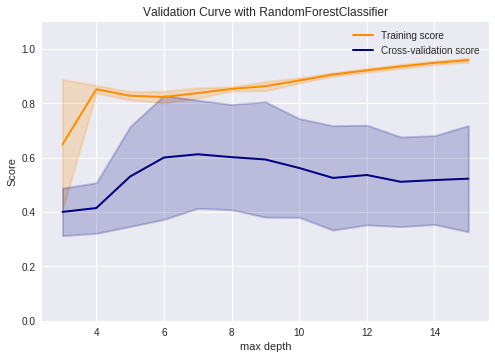

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
X, y = mov_sel, labels

# param_range = np.logspace(-6, 5, 5)
param_range = np.arange(3,16,1)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(min_samples_split=2, n_estimators=40), X, y, param_name="max_depth", param_range=param_range,
    cv=5, scoring="precision_macro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [95]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_sel, labels, test_size=0.2, random_state=i)
  from sklearn import metrics
  RFC = RandomForestClassifier(max_depth=8, min_samples_split=2, n_estimators=40)
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)
# print('Accuracy: {:.2f}'.format(accuracy_avg))

[[541.1  15.8]
 [189.   33.1]]


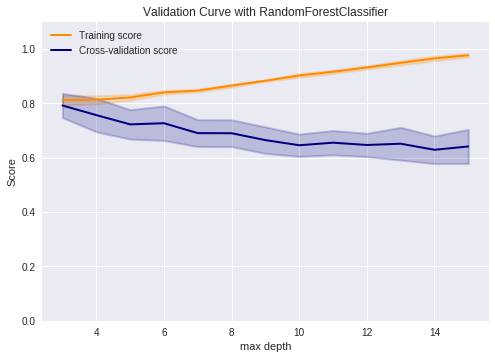

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
X, y = mov_pca_Df, labels

# param_range = np.logspace(-6, 5, 5)
param_range = np.arange(3,16,1)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(min_samples_split=2, n_estimators=40), X, y, param_name="max_depth", param_range=param_range,
    cv=5, scoring="precision_macro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [96]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_sel, labels, test_size=0.2, random_state=i)
  from sklearn import metrics
  RFC = RandomForestClassifier(max_depth=8, min_samples_split=2, n_estimators=40)
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)
# print('Accuracy: {:.2f}'.format(accuracy_avg))

[[542.3  14.6]
 [189.5  32.6]]


In [0]:
# from sklearn.metrics import jaccard_similarity_score
# jaccard_similarity_score(y_test.as_matrix(), y_pred)

In [0]:
y_test.as_matrix()

In [0]:
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [0]:
scl=StandardScaler() # do we really need this? Will we try PCA?
mov_sel_st=scl.fit_transform(mov_sel)

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
pca.fit(mov_sel_st)

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [53]:
print(pca.explained_variance_ratio_)  

[0.09061108 0.07739039 0.0707061  0.06956082 0.05904783 0.05421637
 0.05162285 0.04907263 0.04828371 0.04745129 0.04725948 0.04515169
 0.0451125  0.04060035 0.03796678 0.03315845]


In [54]:
sum(pca.explained_variance_ratio_)

0.8672123220069884

In [0]:
mov_pca = pca.fit_transform(mov_sel_st)

In [0]:
# mov_pca_Df = pd.DataFrame(data = mov_pca
#              , columns = ['pc1', 'pc2',
#                           'pc3', 'pc4',
#                           'pc5', 'pc6'])
mov_pca_Df=mov_pca

In [0]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_pca_Df
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":[3,7,15], 
             "min_samples_split":[2,4], "n_estimators":[20]}

scores = ['precision'] #, 'recall'

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [0]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_pca_Df, labels, test_size=0.25, random_state=i)
  from sklearn import metrics
  RFC = RandomForestClassifier(max_depth=3, min_samples_split=4, n_estimators=20)
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)
# print('Accuracy: {:.2f}'.format(accuracy_avg))

In [58]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_sel
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,22,2).tolist(), 
             "min_samples_split":[2], "n_estimators":[40]}

scores = ['precision'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
    print(clf.best_params_)
#     print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print(mean_list)
#     print(means)

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 40}
Grid scores on development set:

0.457 (+/-0.401) for {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 40}
0.728 (+/-0.077) for {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 40}
0.715 (+/-0.089) for {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 40}
0.711 (+/-0.072) for {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 40}
0.709 (+/-0.073) for {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 40}
0.711 (+/-0.048) for {'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 40}
0.709 (+/-0.064) for {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 40}
0.690 (+/-0.054) for {'max_depth': 17, 'min_samples_split': 2, 'n_estimators': 40}
0.682 (+/-0.050) for {'max_depth': 19, 'min_samples_split': 2, 'n_estimators': 40}
0.686 (+/-0.033) for {'max_depth': 21, 'min_samples_split': 2, 'n_estimators': 40}



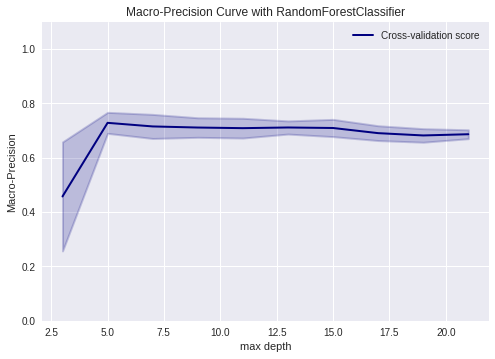

In [59]:
param_range = np.arange(3,22,2)
# param_range = np.logspace(-6, 5, 5)

plt.title("Macro-Precision Curve with RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("Macro-Precision")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [108]:
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_pca_Df
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,16,1).tolist(), 
             "min_samples_split":[2], "n_estimators":[40]}

scores = ['precision'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
    print(clf.best_params_)
#     print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test)
#     print(classification_report(y_true, y_pred))
#     print(mean_list)
#     print(means)

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 40}
Grid scores on development set:

0.773 (+/-0.127) for {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 40}
0.727 (+/-0.056) for {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 40}
0.699 (+/-0.045) for {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 40}
0.691 (+/-0.063) for {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 40}
0.686 (+/-0.072) for {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 40}
0.679 (+/-0.043) for {'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 40}
0.657 (+/-0.044) for {'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 40}
0.646 (+/-0.076) for {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 40}
0.637 (+/-0.046) for {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 40}
0.636 (+/-0.061) for {'max_depth': 12, 'min_samples_split': 

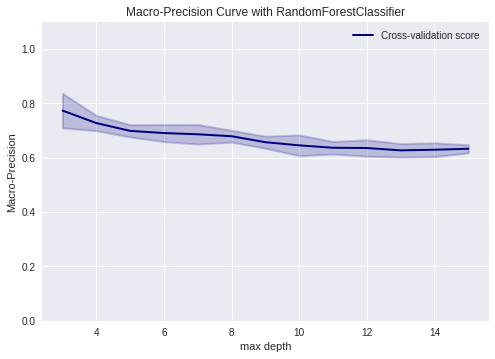

In [109]:
param_range = np.arange(3,22,2)
# param_range = np.logspace(-6, 5, 5)

plt.title("Macro-Precision Curve with RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("Macro-Precision")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [113]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_sel, labels, test_size=0.20, random_state=i)
  from sklearn import metrics
  RFC = RandomForestClassifier(max_depth=6, min_samples_split=2, n_estimators=40)
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)
# print('Accuracy: {:.2f}'.format(accuracy_avg))

[[549.1   7.8]
 [203.4  18.7]]


In [143]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_pca_Df, labels, test_size=0.20, random_state=i)
  from sklearn import metrics
  RFC = LogisticRegression()
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)

[[551.55   5.35]
 [210.2   11.9 ]]


In [140]:
from sklearn.linear_model import LogisticRegression
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_sel
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_iter":np.arange(50,200,20).tolist()}

scores = ['precision'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
    print(clf.best_params_)
#     print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classificatio

{'max_iter': 50}
Grid scores on development set:

0.357 (+/-0.000) for {'max_iter': 50}
0.357 (+/-0.000) for {'max_iter': 70}
0.357 (+/-0.000) for {'max_iter': 90}
0.357 (+/-0.000) for {'max_iter': 110}
0.357 (+/-0.000) for {'max_iter': 130}
0.357 (+/-0.000) for {'max_iter': 150}
0.357 (+/-0.000) for {'max_iter': 170}
0.357 (+/-0.000) for {'max_iter': 190}



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classificatio

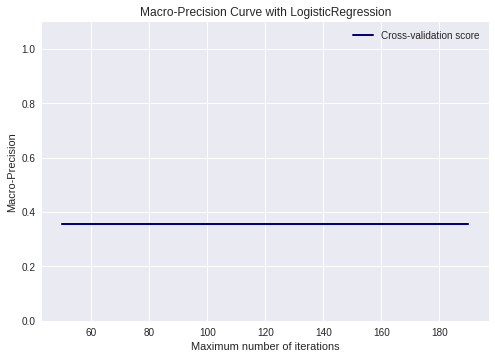

In [141]:
param_range = np.arange(50,200,20)
# param_range = np.logspace(-6, -1, 1)

plt.title("Macro-Precision Curve with LogisticRegression")
plt.xlabel("Maximum number of iterations")
plt.ylabel("Macro-Precision")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [0]:
import statsmodels.api as sm
logit_model=sm.Logit(labels,mov_sel)
result=logit_model.fit()
print(result.summary())

In [130]:
import statsmodels.api as sm
logit_model=sm.Logit(labels,mov_pca_Df)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.587458
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          gross_RoI_cut   No. Observations:                 3891
Model:                          Logit   Df Residuals:                     3875
Method:                           MLE   Df Model:                           15
Date:                Tue, 17 Apr 2018   Pseudo R-squ.:                 0.01818
Time:                        18:29:49   Log-Likelihood:                -2285.8
converged:                       True   LL-Null:                       -2328.1
                                        LLR p-value:                 9.723e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7348      0.186      3.959      0.000       0.371       1.099
x2             1.6684      0.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
X, y = mov_sel, labels

# param_range = np.logspace(-6, 5, 5)
param_range = np.arange(3,16,1)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(min_samples_split=2, n_estimators=20), X, y, param_name="max_depth", param_range=param_range,
    cv=4, scoring="precision_macro", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [0]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
X, y = mov_pca_Df, labels

# param_range = np.logspace(-6, 5, 5)
param_range = np.arange(2, 20, 5)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(max_features="sqrt",max_depth=15, n_estimators=20), X, y, param_name="min_samples_split", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("min samples split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [0]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import validation_curve
X, y = mov_pca_Df, labels

# param_range = np.logspace(-6, 5, 5)
param_range = np.arange(2, 10, 2)
train_scores, test_scores = validation_curve(
    XGBClassifier(), X, y, param_name="max_depth", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with XGBClassifier")
plt.xlabel("max depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [0]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import validation_curve
X, y = mov_pca_Df, labels

# param_range = np.logspace(-6, 5, 5)
param_range = np.arange(0.05, 0.12, 0.01)
train_scores, test_scores = validation_curve(
    XGBClassifier(), X, y, param_name="learning_rate", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with XGBClassifier")
plt.xlabel("learning rate")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [60]:
from xgboost.sklearn import XGBClassifier
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_sel
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,22,2).tolist()}

scores = ['precision'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(XGBClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
    print(clf.best_params_)
#     print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

{'max_depth': 3}
Grid scores on development set:

0.681 (+/-0.016) for {'max_depth': 3}
0.671 (+/-0.046) for {'max_depth': 5}
0.668 (+/-0.037) for {'max_depth': 7}
0.651 (+/-0.033) for {'max_depth': 9}
0.645 (+/-0.018) for {'max_depth': 11}
0.643 (+/-0.037) for {'max_depth': 13}
0.651 (+/-0.019) for {'max_depth': 15}
0.643 (+/-0.052) for {'max_depth': 17}
0.645 (+/-0.045) for {'max_depth': 19}
0.645 (+/-0.038) for {'max_depth': 21}



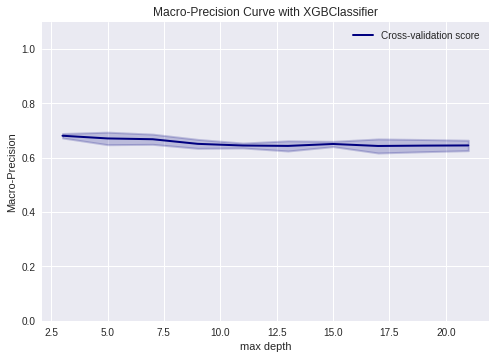

In [61]:
param_range = np.arange(3,22,2)
# param_range = np.logspace(-6, -1, 1)

plt.title("Macro-Precision Curve with XGBClassifier")
plt.xlabel("max depth")
plt.ylabel("Macro-Precision")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [149]:
from xgboost.sklearn import XGBClassifier
from __future__ import print_function

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print(__doc__)


# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X = mov_pca_Df
y = labels

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.0, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = { "max_depth":np.arange(3,16,1).tolist()}

scores = ['precision'] #, 'recall'

mean_list=[]
std_list=[]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(XGBClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

#     print("Best parameters set found on development set:")
#     print()
    print(clf.best_params_)
#     print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        mean_list.append(mean)
        std_list.append(std)
    print()

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

{'max_depth': 5}
Grid scores on development set:

0.636 (+/-0.037) for {'max_depth': 3}
0.641 (+/-0.062) for {'max_depth': 4}
0.649 (+/-0.043) for {'max_depth': 5}
0.638 (+/-0.037) for {'max_depth': 6}
0.635 (+/-0.050) for {'max_depth': 7}
0.628 (+/-0.028) for {'max_depth': 8}
0.616 (+/-0.015) for {'max_depth': 9}
0.624 (+/-0.051) for {'max_depth': 10}
0.624 (+/-0.033) for {'max_depth': 11}
0.618 (+/-0.047) for {'max_depth': 12}
0.619 (+/-0.046) for {'max_depth': 13}
0.627 (+/-0.024) for {'max_depth': 14}
0.623 (+/-0.040) for {'max_depth': 15}



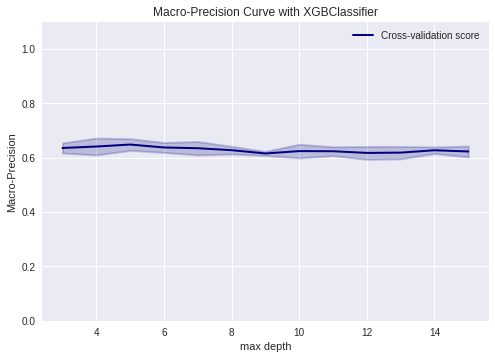

In [150]:
param_range = np.arange(3,16,1)
# param_range = np.logspace(-6, -1, 1)

plt.title("Macro-Precision Curve with XGBClassifier")
plt.xlabel("max depth")
plt.ylabel("Macro-Precision")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training with cv",
#              color="darkorange", lw=lw)
# plt.plot(param_range, np.asarray(mean_list), label="Training with cv",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
plt.plot(param_range, np.asarray(mean_list), label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, np.asarray(mean_list) - np.asarray(std_list),
                 np.asarray(mean_list) + np.asarray(std_list), alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [154]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_sel, labels, test_size=0.20, random_state=i)
  from sklearn import metrics
  RFC = XGBClassifier(max_depth=6)
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[[503.1   53.8 ]
 [151.95  70.15]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [145]:
confusion_matrix_avg=np.zeros((2,2))
# accuracy_avg=0.0
times=20
for i in range(times):
  from sklearn.cross_validation import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(mov_pca_Df, labels, test_size=0.20, random_state=i)
  from sklearn import metrics
  RFC = XGBClassifier()
  RFC.fit(X_train, y_train)
  y_pred = RFC.predict(X_test)
#   print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(RFC.score(X_test, y_test)))
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_avg=confusion_matrix_avg+confusion_matrix
#   accuracy_avg=(confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]))/2+accuracy_avg
confusion_matrix_avg=confusion_matrix_avg/times
# accuracy_avg=accuracy_avg/times
print(confusion_matrix_avg)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[[534.15  22.75]
 [193.2   28.9 ]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
